<a href="https://colab.research.google.com/github/euxoa/ompeluseura/blob/master/Ompeluseura_apt_get.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
start_time <- Sys.time()

In [2]:
# install.packages takes ages (20mins) in Colab so we will install dependencies apt-get
system("apt-get update")
system("apt install -y r-cran-readr")
system("apt install -y r-cran-dplyr")
system("apt install -y r-cran-rstan")
system("apt install -y r-cran-bayesplot")
print(Sys.time() - start_time)

Time difference of 11.94227 secs


In [3]:
options(repr.plot.width  = 8, repr.plot.height = 4)
Sys.setenv(USE_CXX14 = 1) # use C++14 compiler

library("rstan") # observe startup messages


Loading required package: StanHeaders
Loading required package: ggplot2
rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


In [0]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)
library("bayesplot")

In [0]:
library("dplyr")
library("ggplot2")

In [6]:
print(Sys.time() - start_time)

Time difference of 1.010216 mins


The data consists of average monthly temperatures from the FMI Kilpisjärvi station, for the last four decades. FMI has their own API, but casual downloads are easiest through their interactive service at https://ilmatieteenlaitos.fi/havaintojen-lataus#!/

Why Kilpisjärvi? Its a beautiful place, one of the few mountaineous areas in Finland. Its high latitude its temperature interesting, for warming due to greenhouse gases tends to be much more pronounced in the artic than on southern latitudes. The scripts on this notebook are general though, so that you can insert data from your favorite locations easily.

In [0]:
d <- readr::read_csv("https://raw.githubusercontent.com/euxoa/ompeluseura/master/kilpisjarvi_raw.csv") %>% 
  setNames(c("year", "month", "day", "_clock", "tzone", "temp")) %>%
  mutate(t = ISOdate(year, month, day), 
         f_month = as.factor(month),
         decade = as.numeric(t - ISOdate(2000, 1, 1), units="days")/365.25) %>%
  select(year, f_month, t, decade, temp)


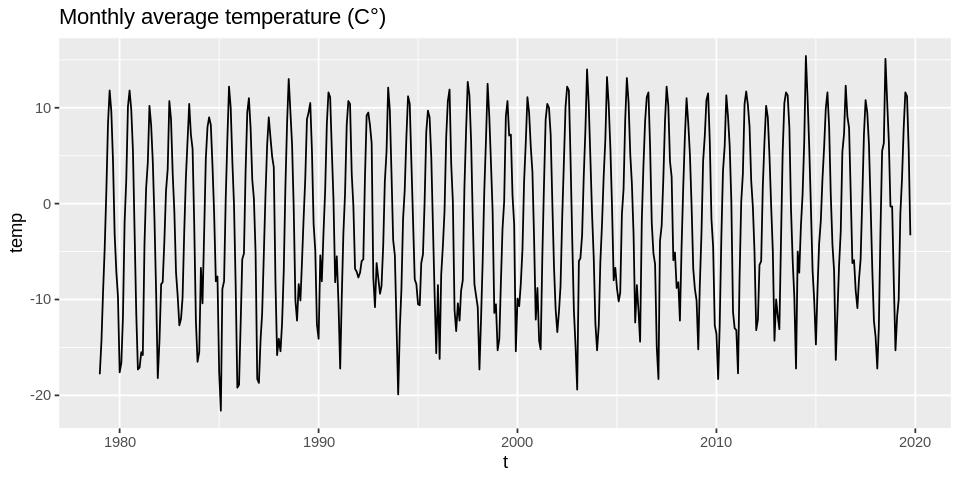

In [8]:
ggplot(d, aes(x=t, y=temp)) + geom_line() + labs(title = "Monthly average temperature (C°)")

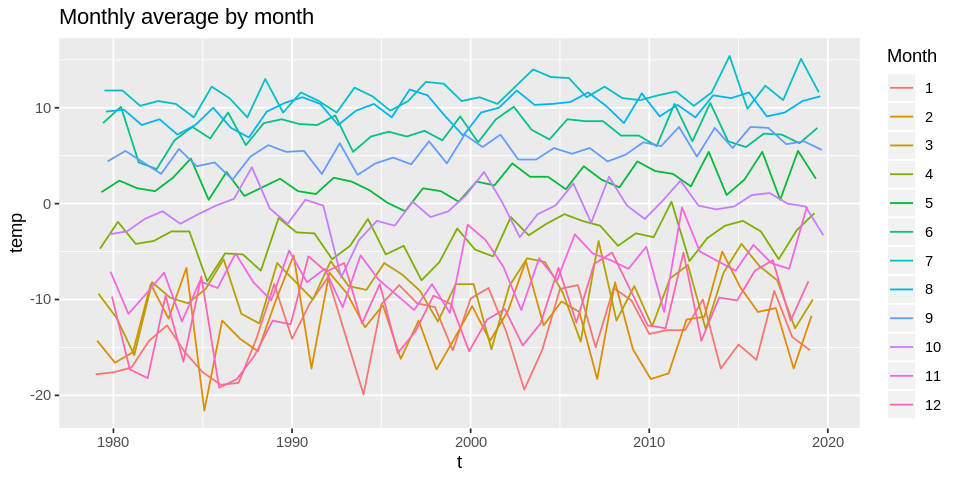

In [9]:
ggplot(d, aes(x=t, y=temp, color=f_month)) + geom_line() + labs(title = "Monthly average by month", color= "Month")

An upward trend is obvious. Note high variance of the winter months!

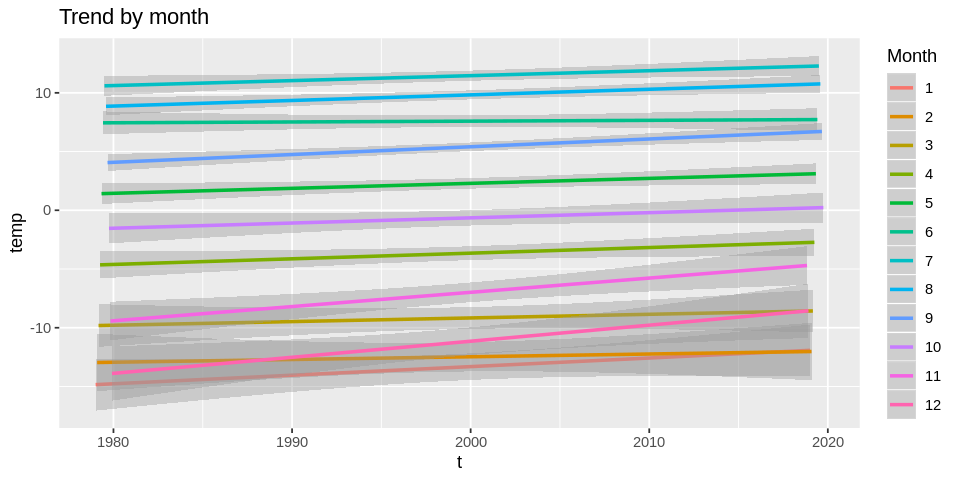

In [10]:
ggplot(d, aes(x=t, y=temp, color=f_month)) + geom_smooth(method="lm") + labs(title = "Trend by month", color= "Month")

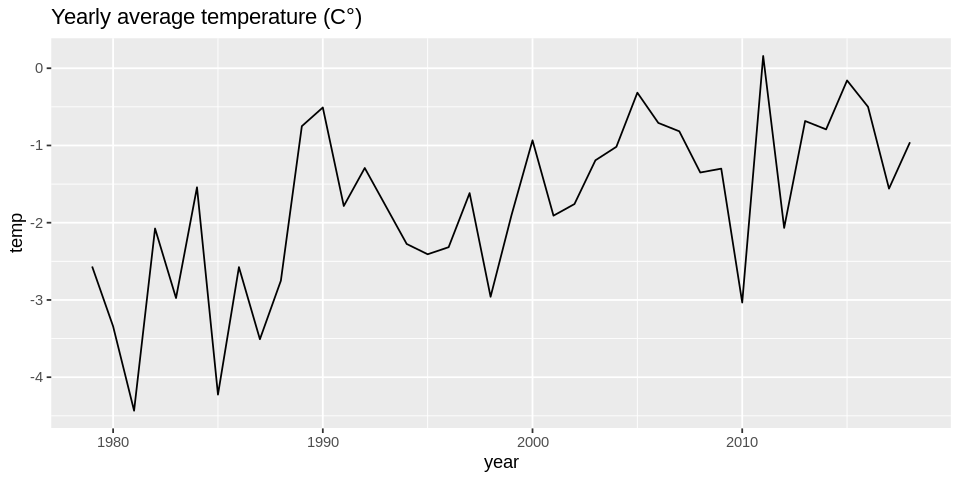

In [11]:
d_year <- d %>% group_by(year) %>% summarise(n=n(), temp=mean(temp), decade=mean(decade)) %>% filter(n==12)

ggplot(d_year, aes(x=year, y=temp)) + geom_line() + labs(title = "Yearly average temperature (C°)")

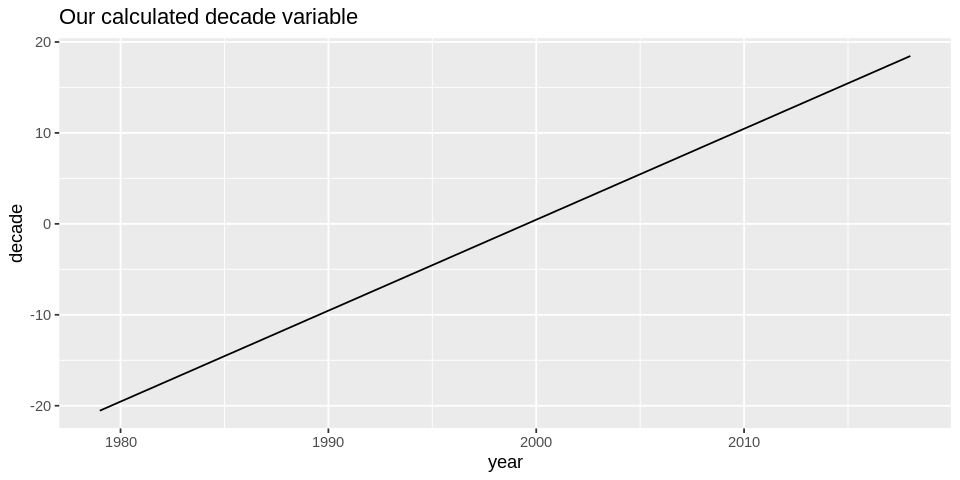

In [12]:
# Our calculated decade variable is just distance from 1.1.2000 in years. It's the time variable with a sane variance.
ggplot(d_year, aes(x=year, y=decade)) + geom_line() + labs(title = "Our calculated decade variable")

In [0]:
stan_data_yearly <- with(d_year, list(N=length(temp), decade=decade, temp=temp))

In [0]:
compile_and_fit_model <- function(model_code, data, vars_of_interest) {
  stan_start_time <- Sys.time()
  model <- stan_model(model_code = model_code) # compilation takes time if model is changed
  fit <- sampling(model, data = data)
  message("Compilation and fitting in secs ", difftime(Sys.time(), stan_start_time, units="secs"))
  
  posterior <- as.matrix(fit)
  print(traceplot(fit))
  print(fit)

  # Print posterior distributions for interesting variables
  posterior <- as.matrix(fit)
  for (var_name in vars_of_interest)
  {
    plot <- mcmc_areas(posterior, pars = c(var_name), prob = 0.8)  + 
      ggtitle(paste("Variable ", var_name, " posterior distributions with median and 80% interval"))
    print(plot)  
  }

  message("Total duration in secs ", difftime(Sys.time(), stan_start_time, units="secs"))
  return(fit)
}

The first model is a linear regression on the data aggregated to yearly level.

Compilation and fitting in secs 77.5317175388336


Inference for Stan model: 1ba1786ebbac82d7206777eaaf7e168e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
a      -1.70    0.00 0.15  -1.99  -1.81  -1.71  -1.61  -1.42  3507    1
b       0.06    0.00 0.01   0.04   0.05   0.06   0.07   0.08  3621    1
sigma   0.90    0.00 0.11   0.71   0.82   0.89   0.96   1.15  3400    1
lp__  -14.56    0.03 1.30 -17.96 -15.13 -14.23 -13.60 -13.07  1891    1

Samples were drawn using NUTS(diag_e) at Sat Dec  7 20:20:56 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Total duration in secs 78.7457473278046


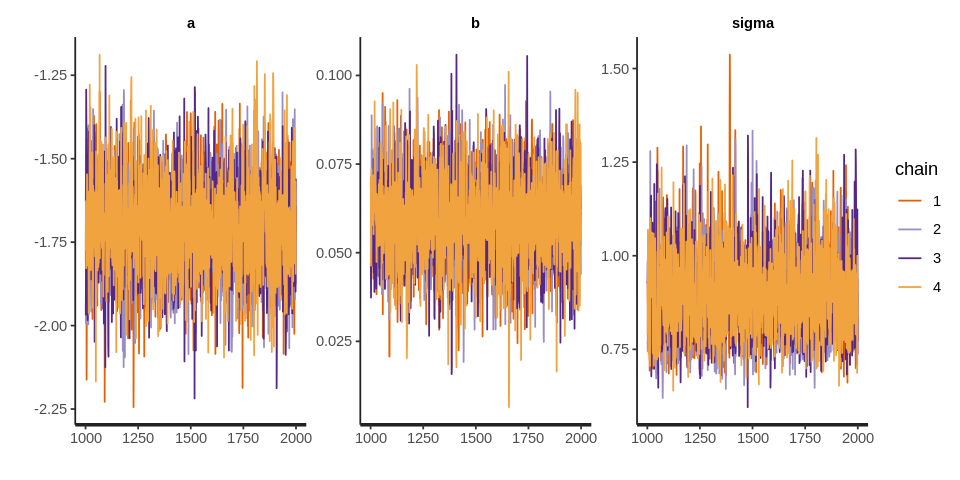

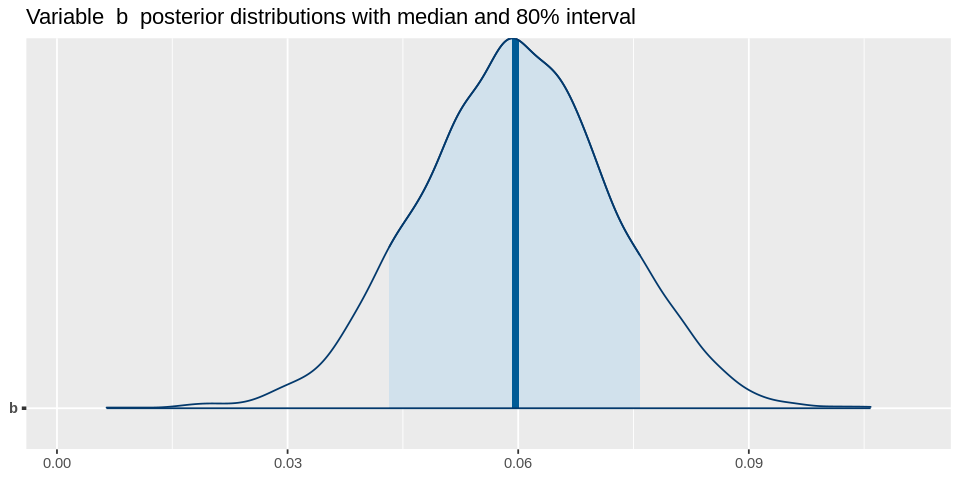

In [14]:
model_simple_normal <- "
data {
  int<lower=0> N;
  vector[N] decade;
  vector[N] temp;
}
parameters {
  real a;
  real b;
  real<lower=0> sigma;
}
model {
  temp ~ normal(a + b * decade, sigma);
}
"
fit_sn <- compile_and_fit_model(model_code = model_simple_normal, data = stan_data_yearly, vars_of_interest = c("b"))


In the second model, we take monthly data, and fit linear regression lines to each of the months separately. 

In [0]:
stan_data_monthly <- with(d, list(N=length(temp), decade=decade, month=as.integer(f_month), temp=temp))

Compilation and fitting in secs 78.225076675415
'pars' not specified. Showing first 10 parameters by default.


Inference for Stan model: 9a2d1e14cab629b91a257d84eadcb8b4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
sigma[1]     3.63    0.01 0.43    2.91    3.32    3.59    3.89    4.58  5244
sigma[2]     4.03    0.01 0.46    3.22    3.70    3.99    4.31    5.08  5953
sigma[3]     3.01    0.01 0.35    2.42    2.75    2.98    3.23    3.77  4984
sigma[4]     1.93    0.00 0.22    1.55    1.77    1.91    2.06    2.43  5891
sigma[5]     1.47    0.00 0.18    1.18    1.35    1.45    1.58    1.86  5091
sigma[6]     1.62    0.00 0.19    1.29    1.48    1.60    1.73    2.05  4775
sigma[7]     1.42    0.00 0.17    1.14    1.30    1.40    1.52    1.80  5373
sigma[8]     1.26    0.00 0.15    1.00    1.15    1.25    1.35    1.60  5293
sigma[9]     1.19    0.00 0.14    0.95    1.09    1.18    1.28    1.51  5209
sigma[10]    2.13    0.00 0.26    1.71    1.95    2.

Total duration in secs 80.048262834549


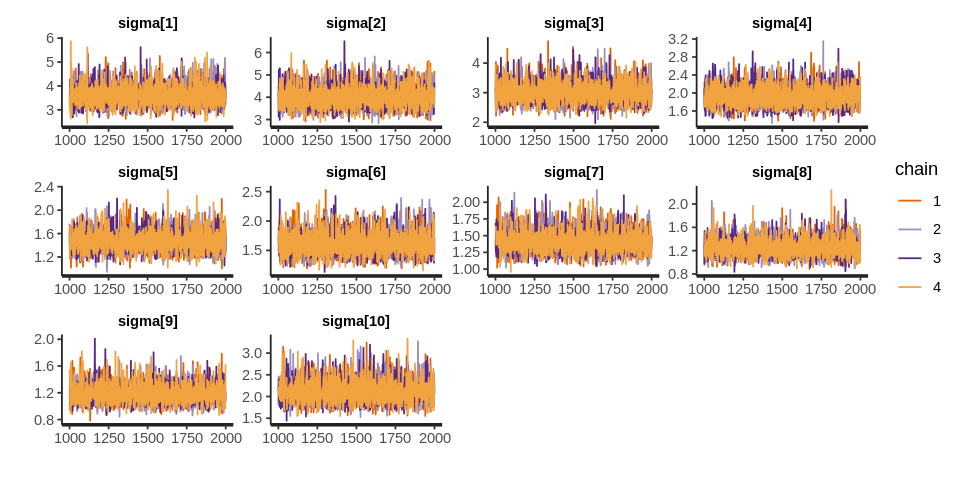

In [16]:

monthly_model_code <- "
data {
  int N;
  real decade[N];
  real temp[N];
  int month[N];
}
parameters {
  real<lower=0> sigma[12];
  real b[12];
  real k[12];
}
model {
  for (i in 1:N) {
     int m = month[i];
     temp[i] ~ normal(k[m] * decade[i] + b[m], sigma[m]); }
  sigma ~ normal(0, 5);
  b ~ normal(0, 5);
  k ~ normal(0, 1);
}
"
fit <- compile_and_fit_model(model_code = monthly_model_code, data = stan_data_monthly, vars_of_interest = c())

You can plot samples of the model, for example by variable pairs.

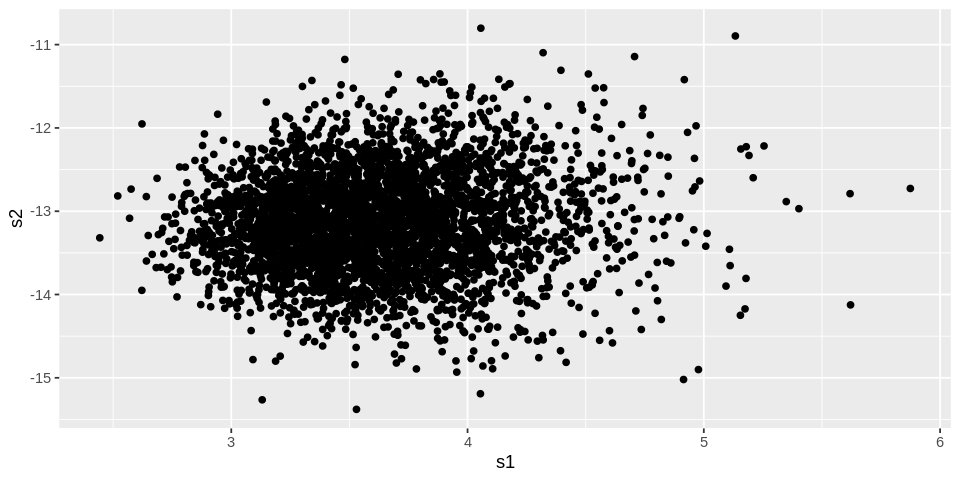

In [20]:
data.frame(s1=extract(fit, "sigma[1]")[[1]], s2=extract(fit, "b[1]")[[1]]) %>% ggplot(aes(x=s1, y=s2)) + geom_point() #+ coord_equal()

Below, the change of temperature per decade, by month. Note the higher uncertainty of winter months!

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


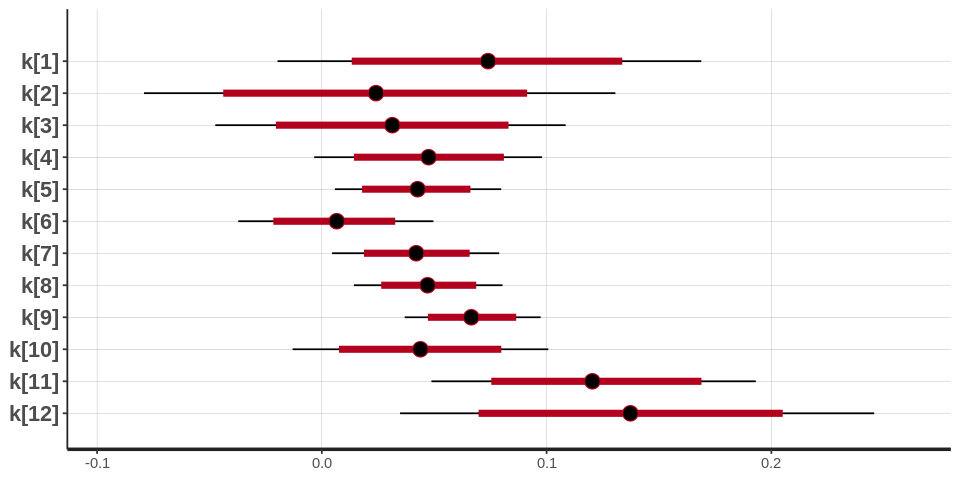

In [21]:
plot(fit, pars="k")

Winter months also have higher residual variance.

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


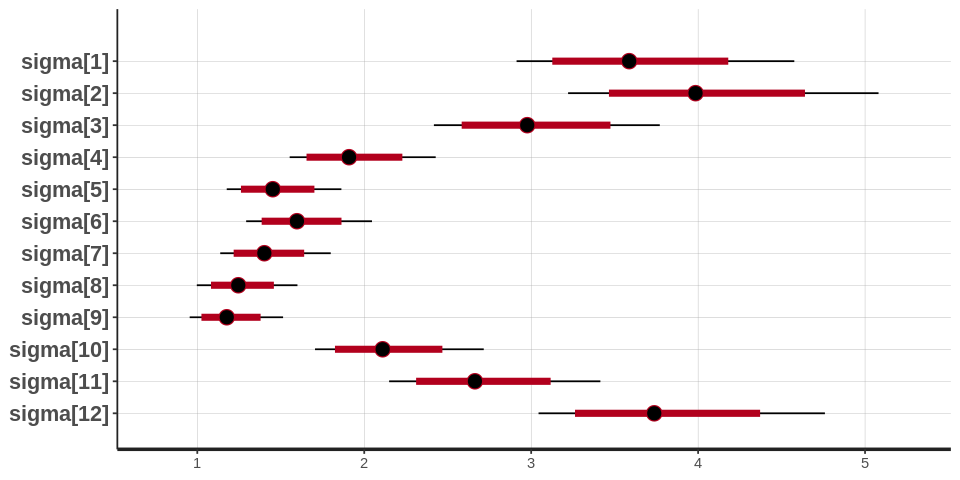

In [22]:
plot(fit, pars="sigma")

You can do hypothesis testing with the samples.

[1] 0.989

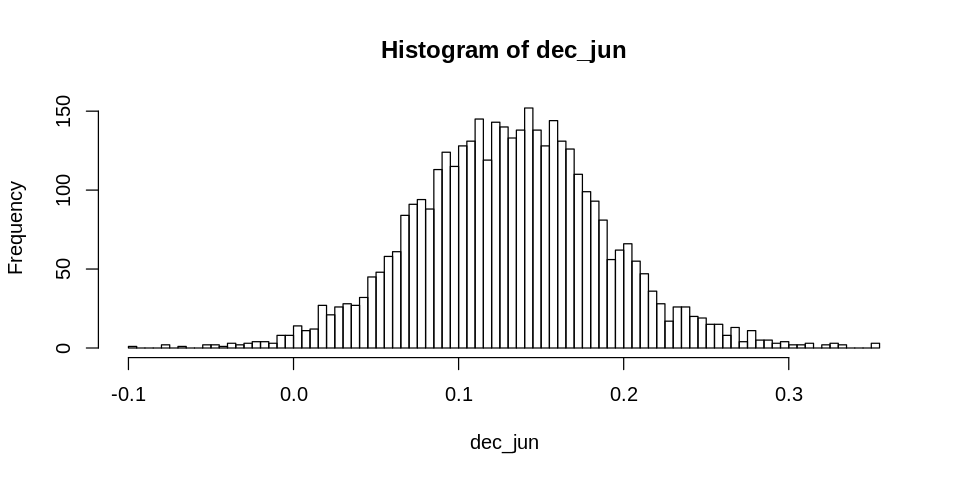

In [39]:
dec_jun <- extract(fit, "k[12]")[[1]] - extract(fit, "k[6]")[[1]]
mean(dec_jun>0)
hist(dec_jun, n=100)

Warning message:
“There were 137 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Warning message:
“The largest R-hat is 1.06, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help

Inference for Stan model: 5c61028bc5cc19e7572c47dc8d4c9c8a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean    sd    2.5%     25%     50%     75%   97.5%
sigma[1]          3.59    0.01  0.42    2.90    3.29    3.53    3.84    4.53
sigma[2]          4.01    0.01  0.46    3.23    3.69    3.98    4.29    5.02
sigma[3]          2.98    0.01  0.33    2.42    2.75    2.95    3.18    3.69
sigma[4]          1.92    0.00  0.22    1.53    1.76    1.90    2.06    2.41
sigma[5]          1.46    0.00  0.16    1.18    1.34    1.44    1.56    1.81
sigma[6]          1.66    0.00  0.19    1.34    1.53    1.64    1.78    2.09
sigma[7]          1.40    0.00  0.17    1.12    1.29    1.38    1.50    1.78
sigma[8]          1.24    0.00  0.14    1.01    1.15    1.23    1.33    1.56
sigma[9]          1.20    0.01  0.15    0.96    1.10    1.18    1.29    1.52
sigma[10]         2.11    0.00  0.24    1.70    1.94

Total duration in secs 156.850695848465


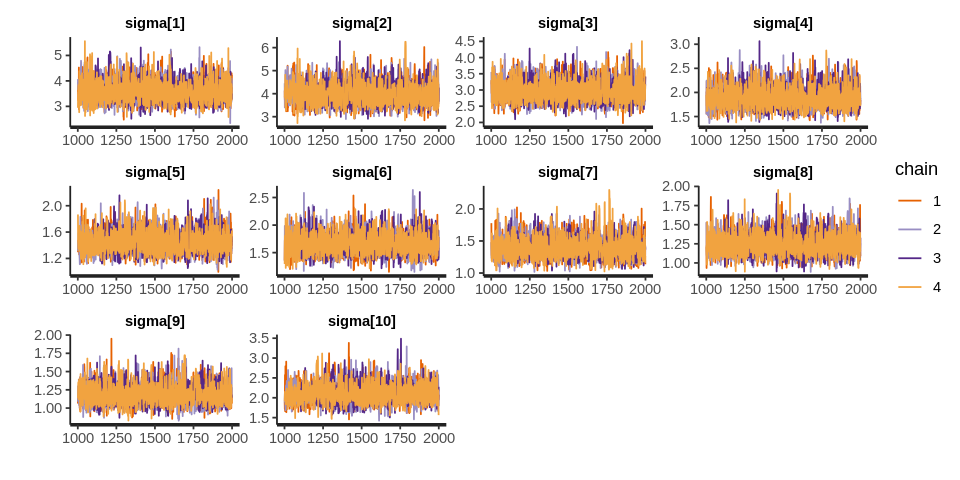

In [44]:
monthly_model_code2 <- "
data {
  int N;
  real decade[N];
  real temp[N];
  int month[N];
}
parameters {
  real<lower=0> sigma[12];
  real b[12];
  real k[12];
  real<lower=0> sigma_change_k;
}
model {
  for (i in 1:N) {
     int m = month[i];
     temp[i] ~ normal(k[m] * decade[i] + b[m], sigma[m]); }
  sigma ~ normal(0, 5);
  b ~ normal(0, 5);
  for (i in 2:12)
     k[i] ~ normal(k[i-1], sigma_change_k);
  k[1] ~ normal(k[12], sigma_change_k);
  k[5] ~ normal(0, 1); // Any k will do to fix the overall level.
}
"
fit2 <- compile_and_fit_model(model_code = monthly_model_code2, data = stan_data_monthly, vars_of_interest = c())

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)
ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


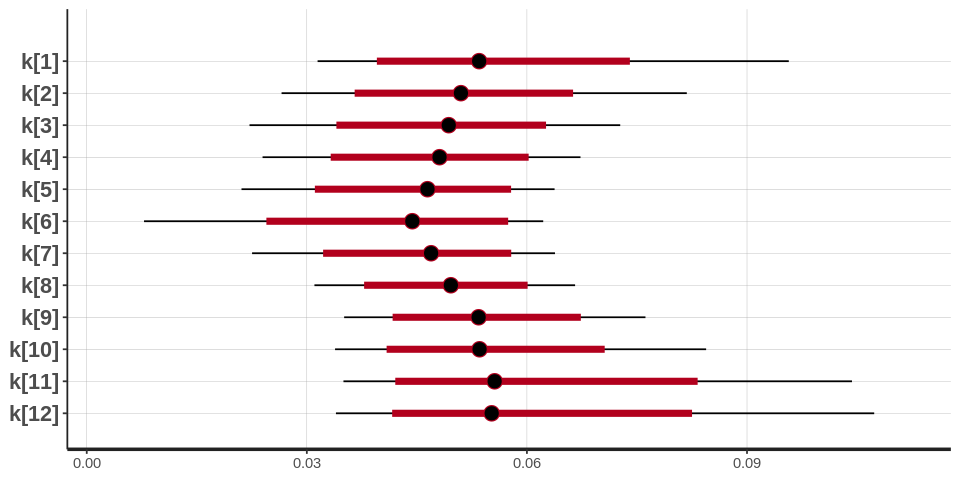

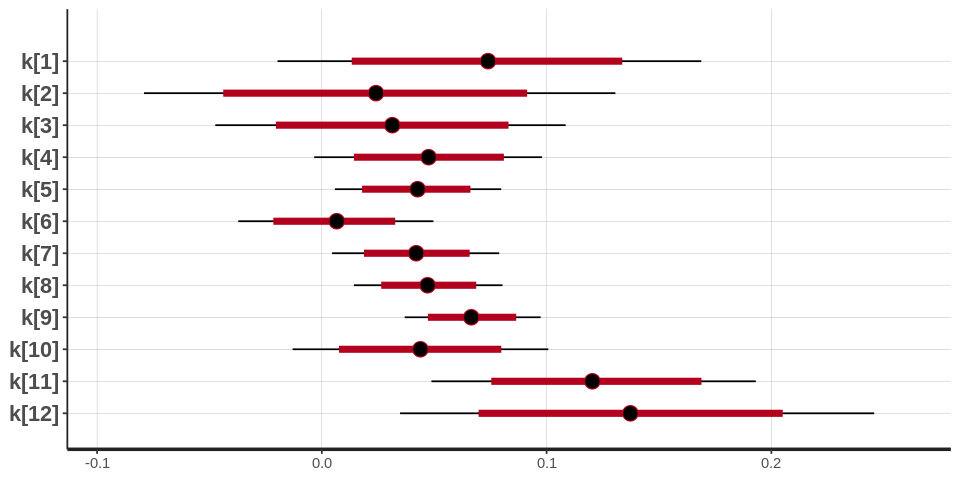

In [45]:
plot(fit2, pars="k")
plot(fit, pars="k")

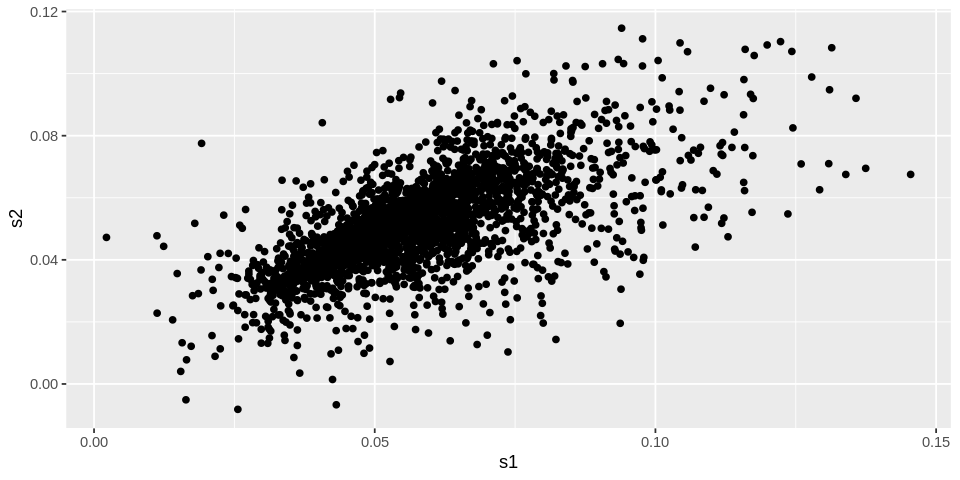

In [47]:
data.frame(s1=extract(fit2, "k[1]")[[1]], s2=extract(fit2, "k[2]")[[1]]) %>% ggplot(aes(x=s1, y=s2)) + geom_point() #+ coord_equal()